## Assignment 3 Question 2

#### Import Libraries

In [3]:
import pandas as pd
import chess
import chess.pgn
import chess.engine
import io
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import math
import data_cleaning

from pandarallel import pandarallel
from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# Need pyarrow package for parquet parsing

#### Import stockfish 🐟🐟🐟

In [4]:
# Windows installation
# STOCKFISH_LOC = os.getcwd() + "\stockfish_15_1\stockfish-windows-2022-x86-64-avx2.exe"
STOCKFISH_LOC = os.getcwd() + "\stockfish_14_win_x64\stockfish_14_x64.exe"
# Unix based installation i.e. DICE/Codespaces
STOCKFISH_LOC_UNIX = os.getcwd() + "/stockfish_14_linux/stockfish_14_x64"

# Import stockfish package
from stockfish import Stockfish
# Try and read windows location
try:
    fish = Stockfish(path=STOCKFISH_LOC, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# If error, read the linux location
except:
    fish = Stockfish(path=STOCKFISH_LOC_UNIX, depth=10, parameters={"Threads": 2, "Hash": 32})
    
# It will throw an error but if it still runs then ignore it

#### Import cleaned CSV file

60718 entries in dataframe

In [5]:
chess_data = data_cleaning.import_data()
chess_data = chess_data.drop(['white_id', 'black_id', 'white_result', 'black_result', 'rules'], axis=1)
print(len(chess_data))

60718


### Processing data and adding information

#### Checks every game for ones that have potential en-passant moves
- Gets whether a game has an en-passant opportunity
- Gets whether the said en passant move was played
- Gets the colour of the player that has the e.p. opportunity

In [6]:
def check_pgn(df_row):
    '''
    Checks PGN for whether opportunity for EP happened in the game.
    '''
    
    # needs individual imports for pandarallel
    import io
    import chess
    import chess.pgn
    
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    
    # pre-initialise df_row values
    precheck = False
    moved = False
    move_colour = ""

    # comparison sets when checking move piece
    ep_set = set(["ax","bx","cx","dx","ex","fx","gx", "hx"])
    check_set = set("abcdefgh")
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        move = board_move.move  # Move in square form
        san = board.san(move)   # Move in SAN form
        turn = board.turn       # Colour of player making turn
        move_piece = san[0]     # First letter of san (indicates piece)

        # check if precheck was flagged in previous move
        if precheck:
            # get first 2 letters, and compare to a set
            move_ep_piece = san[:2]
            if move_ep_piece in ep_set:
                # check if e.p. actually happened
                moved = board.is_en_passant(move)
            # break out for loop, no need to check further
            break
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
            # if precheck is true then set the turn
            if precheck:
                if turn:
                    move_colour = 'Black'
                else:
                    move_colour = 'White'
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    
    # set row values
    df_row["ep_opportunity"] = precheck
    df_row["ep_happened"] = moved
    df_row["ep_colour"] = move_colour
    return df_row

# chess filter is a copy of chess_data (just in case)
chess_filter = chess_data.copy(deep=True)

# parallel function initialise
pandarallel.initialize()

# apply parallel e.p. finding function
try:
    chess_filter = chess_filter.parallel_apply(check_pgn, axis=1)
# if it doesn't work, regular apply function
except:
    chess_filter = chess_filter.apply(check_pgn, axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


#### Filter out games that don't have en-passant opportunity

In [7]:
# only games that have ep opportunity
chess_filter = chess_filter[chess_filter['ep_opportunity'] == True]
# drop rest of games
chess_filter = chess_filter.drop(['ep_opportunity'], axis=1)
# reset index
chess_filter = chess_filter.reset_index(drop=True)

print("Games with opportunity: " + str(len(chess_filter)))
print("Games with ep move: " + str(len(chess_filter[chess_filter['ep_happened'] == True])))

Games with opportunity: 5074
Games with ep move: 1563


#### Get the time taken to respond to an en-passant pawn move

In [8]:
def check_times(df_row):
    '''
    Checks PGN for the time taken to play a move
    '''
    
    import io
    import chess
    import chess.pgn

    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game
    # pre-initialise df_row values
    precheck = False

    # comparison sets when checking move piece
    check_set = set("abcdefgh")
    
    # previous and current times, to take a difference when stopping
    rolling_white_time = [0,0]
    rolling_black_time = [0,0]
    
    # Find only pawn moves in game
    for board_move in game.mainline():
        # if turn is white, update white
        if board.turn:
            rolling_white_time = [board_move.clock(), rolling_white_time[0]]
        # if turn is black, update white
        else:
            rolling_black_time = [board_move.clock(), rolling_black_time[0]]
        
        # move and san
        move = board_move.move
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # get first 2 letters, and compare to a set
            norm = df_row["time_control"]

            # if was white
            if board.turn:
                # take the difference over the total time
                df_row["time_taken"] = (rolling_white_time[1] - rolling_white_time[0])/float(norm)
            # if was black do the same thing
            else:
                df_row["time_taken"] = (rolling_black_time[1] - rolling_black_time[0])/float(norm)
            # return row
            return df_row
        
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move)
    return df_row

# parallel processing
pandarallel.initialize()

# if device supports parallel processing then apply, else use regular apply
try:
    chess_filter = chess_filter.parallel_apply(check_times, axis=1)
except:
    chess_filter = chess_filter.apply(check_times, axis=1)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


#### Stockfish Evaluation to get evaluations of board choices
- Gets the evaluation before an ep opportunity
- Gets the evaluation of the best move calculated by Stockfish
- Gets the evaluation of the (best) en passant move calculated by Stockfish

In [9]:
# reload eval file
import stockfish_eval
importlib.reload(stockfish_eval);

def stockfish_analyse_board(df_row, board, move):
    '''
    Gets a stockfish evaluation of the best move played, if e.p. is played,
    and the stockfish evaluation of the player's move
    
    Returns the pre-move evaluation, evaluation of best move, evaluation
    of (best) en passant move, evaluation of players move. evals are an absolute
    value so the same for both sides, and calculated as the difference from the pre-move

    '''
    
    # initialise stockfish
    fish_eval = stockfish_eval.StockfishEval(fish, board, df_row["ep_colour"])

    # reset fen to board position
    fish_eval.reset_fen()
    
    # set the player move class variable
    fish_eval.set_player_move(move)
    # get pre-move stockfish evaluation of board
    pre_eval = fish_eval.evaluate_board()["value"]
    
    # get the best move and store in class variable
    fish_eval.find_best_move()
    
    # find adjacent squares to pawn move
    fish_eval.find_adj_squares()
    # find if square is on a left bound (A file) or right bound (H file)
    fish_eval.find_bounds()
    # find if each valid square is also a valid (opposing) pawn
    fish_eval.find_valid_pawns()

    # find a fen representation of each move
    fish_eval.find_ep_moves()
        
    
    move_list = fish_eval.get_movelist()
    # should end up with move_list class variable in the following configs
    
    # | best_move | player_move | ep_move_left | ep_move_right|
    # |===========|=============|==============|==============|
    # |   move    |    move     |     move     |     move     |
    # |   move    |    move     |     ----     |     move     |
    # |   move    |    move     |     move     |     ----     |
    
    # get the evaluation of the best move, and absolute advantage
    best_eval = fish_eval.evaluate_move(move_list["best_move"])
    best_difference = fish_eval.get_abs_advantage(best_eval, pre_eval)
    
    
    # lookup table of en-passant moves
    ep_moves = [move_list["ep_move_left"], move_list["ep_move_right"]]
    # if the best move is also an en-passant
    
    if move_list["best_move"] in ep_moves:
        # set the ep_eval to best val. This is for consistency because
        # stockfish returns a different evaluation each time you run a move
        
        ep_eval = best_eval
        ep_difference = best_difference
    else:
        # if it's different, then evaluate e.p. move separately
        # evaluate_en_passants() finds evaluation for both moves,
        # and returns the maximum value i.e. the better e.p. move
        ep_eval = fish_eval.evaluate_en_passants()
        ep_difference = fish_eval.get_abs_advantage(ep_eval, pre_eval)
    
    
    # if the player move is the best move
    if fish_eval.get_movelist()["best_move"] == move:
        # same thing as en-passant
        best_eval = best_eval
        player_difference = best_difference
    else:
        player_eval = fish_eval.evaluate_move(move_list["player_move"])
        player_difference = fish_eval.get_abs_advantage(player_eval, pre_eval)
    
    return [pre_eval, best_difference, ep_difference, player_difference]

def get_advantage(df_row):
    '''
    Get stockfish evaluations for a given game. For a dataframe row,
    sets columns "pre_eval", "eval_best", "eval_ep", "eval_player"
    '''
    
    # pawn lookup set
    check_set = set("abcdefgh")
    # print(df_row.name)
    
    # initialise board
    pgn_file = io.StringIO(df_row["pgn"])   # PGN as a file
    game = chess.pgn.read_game(pgn_file)    # Read PGN and put into game
    board = game.board()                    # "board" of a game

    # e.p. check
    precheck = False
    
    # initialise vars
    pre_eval = 0
    best_eval = 0
    ep_eval = 0
    player_eval = 0
    
    # iterate over every move in a game
    for move in game.mainline_moves():
        # representation of a move
        san = board.san(move)
        move_piece = san[0]

        # check if precheck was flagged in previous move
        if precheck:
            # reset to not flag final move precheck edge case 
            precheck = False

            # analyse board
            values = stockfish_analyse_board(df_row, board, str(move))
            # print(values)
            # set values
            pre_eval = values[0]
            best_eval = values[1]
            ep_eval = values[2]
            player_eval = values[3]
            # break out of for loop since we have all values
            break
            
            
        # if the move was a pawn (lower case)
        if move_piece in check_set:
            # Push the move before checking the board
            board.push(move)
            # check if the next move can be en passant
            precheck = board.has_legal_en_passant()
        # if the move wasn't a pawn then just continue as normal
        else:
            board.push(move) 

    # edge case where the final move was pawn 2 space, and there is no next
    # move to run stockfish_analyse_board. In this case just return NA
    # since there was no best move to compare to if the game has ended
    if precheck:
        pre_eval = pd.NA
        best_eval = pd.NA
        ep_eval = pd.NA
        player_eval = pd.NA
    
    # set dataframe values
    df_row["pre_eval"] = pre_eval     # pre-moved stockfish eval
    df_row["eval_best"] = best_eval  # stockfish eval if best move
    df_row["eval_ep"] = ep_eval
    df_row["eval_player"] = player_eval
    return df_row

In [10]:
def write_fish_to_parquet():
    '''
    Writes a file to parquet with stockfish evaluations for each game
    '''
    # choose fields
    stockfish_eval_dataframe = chess_filter[['pre_eval', 'eval_best', 'eval_ep', 'eval_player']]

    # path for windows
    STOCKFISH_EXPORT_PATH = os.getcwd() + "\data\stockfish_eval_results.parquet"
    # path for linux/etc
    STOCKFISH_EXPORT_PATH_UNIX = os.getcwd() + "/data/stockfish_eval_results.parquet"

    # try for windows
    try:
        stockfish_eval_dataframe.to_parquet(STOCKFISH_EXPORT_PATH)
    # If error, read the linux location
    except:
        stockfish_eval_dataframe.to_parquet(STOCKFISH_EXPORT_PATH_UNIX)

def read_fish_from_parquet(input_df):
    '''
    reads Stockfish evaluations from an exported parquet file
    '''
    STOCKFISH_EXPORT_PATH = os.getcwd() + "\data\stockfish_eval_results.parquet"
    STOCKFISH_EXPORT_PATH_UNIX = os.getcwd() + "/data/stockfish_eval_results.parquet"
    
    try:
        fish_fields = pd.read_parquet(STOCKFISH_EXPORT_PATH)
    # If error, read the linux location
    except:
        fish_fields = pd.read_parquet(STOCKFISH_EXPORT_PATH_UNIX)
    
    chess_filter = pd.concat([input_df, fish_fields], axis=1)
    
    return chess_filter

# # Calculate Stockfish Evals and/or store
# chess_filter = chess_filter.apply(get_advantage, axis=1)
# write_fish_to_parquet()

# # Read pre-existing Stockfish Evals
chess_filter = read_fish_from_parquet(chess_filter)

#### Isolate stats of player with the en-passant opportunity
The other player's Elo and username is irrelevant so drop them

In [11]:
def get_player_stats(df_row):
    '''
    returns the player with e.p. opportunity's ELO and username.
    Also deletes the hanging username/rating fields for both sides.
    '''
    
    # if the rows have already been deleted then just do nothing
    try:
        a = df_row["white_rating"]
    except:
        return df_row
    
    # binary check
    col = df_row["ep_colour"]
    if col == "White":
        elo = df_row["white_rating"]
        user = df_row["white_username"]
    else:
        elo = df_row["black_rating"]
        user = df_row["black_username"]
    
    # set new fields
    df_row["player_rating"] = elo
    df_row["username"] = user
    
    # drop fields
    df_row = df_row.drop(["white_username", "black_username"])
    df_row = df_row.drop(["white_rating", "black_rating"])
    return df_row

chess_filter = chess_filter.apply(get_player_stats, axis=1)

### PCA Prep and calculating Temptation (Likelihood of taking a move)

#### Normal distribution of player Elo

standard deviation: 399.373996237217
mean: 1240.5744974379188


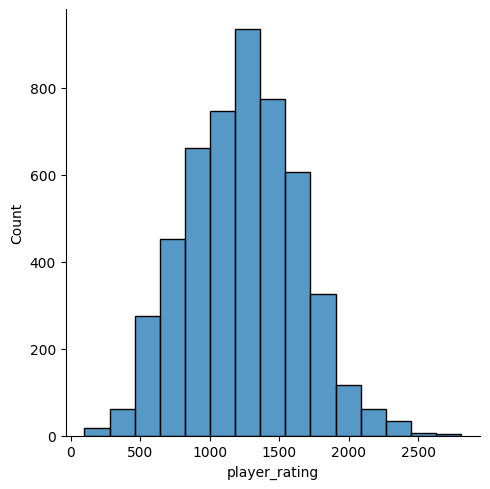

In [12]:
# get sample mean and std
mean = chess_filter["player_rating"].mean()
std = chess_filter["player_rating"].std()

# display normal distribution
fhgt_hist = sns.displot(chess_filter["player_rating"], kde = False, bins = 15)

print("standard deviation: " + str(std))
print("mean: " + str(mean))

#### Getting temptation and ep-capture probability of each player

In [13]:
def group_elo_tens(df_row):
    '''Rounds a player's ELO to the nearest 10 and create a new field for it'''    
    
    df_row["elo_class_tens"] = int(math.ceil(df_row["player_rating"] / 10.0)) * 10
    return df_row

def divider(df_row):
    '''Divides the amount of times en passant happened in an ELO class by
    the total number of en passant opportunities'''
    
    df_row["quotient"] = df_row["instances"] / df_row["total"]
    return df_row

def apply_quotient(df_row):
    '''For each row, store the probability of someone in
    their rounded elo class playing en-passant'''
    
    num = df_row["elo_class_tens"]
    
    # get probability from separate grouped dataframe
    quot = temptation_quotient.loc[num]["quotient"]
    df_row["quotient"] = quot
    return df_row

def temptation(df_row):
    '''For a board state, get the en-passant temptation of said state'''
    
    # arbritrary constant
    const = 220
    temptation = -1*(np.exp((df_row["eval_best"] - df_row["eval_ep"])/const))+1
    
    # if division by zero just exclude
    if (df_row["eval_best"] == 0):
        df_row["temptation"] = pd.NA
    else:
        df_row["temptation"] = temptation
    return df_row

def group_elo_stds(df_row):
    '''Group a player's ELO in larger ELO class for PCA and KNN predictions'''
    
    elo = df_row["player_rating"]
    if elo <= 1000: # approx (mean - std)
        df_row["elo_class"] = 1 # "Low ELO: 0 - ~1000"
    elif elo <= 1400: # approx (mean + std)
        df_row["elo_class"] = 2 # "Average ELO: ~1000 - ~1400"
    else:
        df_row["elo_class"] = 3 # "High ELO: ~1400+"
    return df_row

# copy chess filter
temptation_data = chess_filter.copy(deep=True)

# Group data by 10s
temptation_data = temptation_data.apply(group_elo_tens, axis=1)

# total amount of a group has a potential e.p. move
temptation_totals = temptation_data.groupby('elo_class_tens').size().rename("total")
# amount of times a group actually made the e.p. move
temptation_instances = temptation_data.groupby('elo_class_tens')['ep_happened'].sum().rename("instances")

# get quotient
temptation_quotient = pd.concat([temptation_instances, temptation_totals], axis=1)
temptation_quotient = temptation_quotient.apply(divider, axis=1)

# apply quotient and temptation to main dataframe
temptation_data = temptation_data.dropna()
temptation_data = temptation_data.apply(apply_quotient, axis=1)
temptation_data = temptation_data.apply(temptation, axis=1)
temptation_data = temptation_data.dropna()

# main elo class grouping
temptation_data = temptation_data.apply(group_elo_stds, axis=1)

# filter out any entries with negative time taken (for some reason there are some)
temptation_data = temptation_data[temptation_data["time_taken"] > 0]

# filter out crazy high temptations
temptation_data = temptation_data[temptation_data["temptation"] > -500]
temptation_data = temptation_data[temptation_data["temptation"] <= 500]
temptation_data = temptation_data[temptation_data["temptation"] < 0]

# Save for later function tempting(n)
save_temptation_data = temptation_data.copy(deep=True)

# temptation_data = make_temptation_dataframe()
temp_clone = temptation_data.copy(deep=True)

#### Reason for ELO grouping to classify probability
Ideally we group by player instead of rounding ELOs, but as you can see it does not make a good sample as a majority of players don't have more than 10 entries which will not be very accurate

ELO grouping
standard deviation: 17.943348185429155
mean: 22.352422907488986

username grouping
standard deviation: 4.036735195470186
mean: 1.7370763437179049


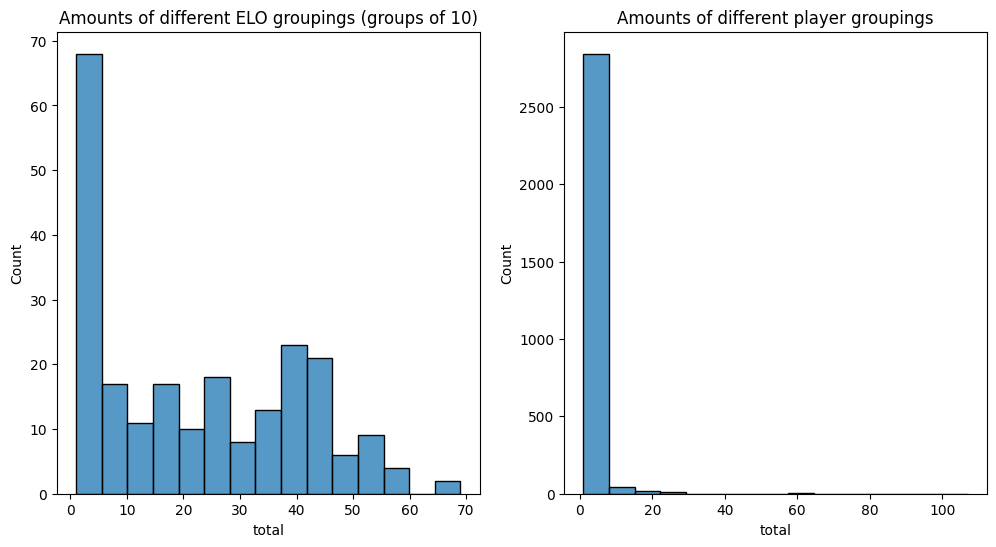

In [14]:
# mini clone of make_temptation_dataframe()
temptation_data_2 = chess_filter.copy(deep=True)

# Group data by 10s
temptation_data_2 = temptation_data_2.apply(group_elo_tens, axis=1)

# total amount of a group has a potential e.p. move
temptation_totals = temptation_data_2.groupby('elo_class_tens').size().rename("total")
# amount of times a group actually made the e.p. move
temptation_instances = temptation_data_2.groupby('elo_class_tens')['ep_happened'].sum().rename("instances")

fig, ax0 = plt.subplots(1,2, figsize=(12, 6))

# data for groups of 10
mean = temptation_totals.mean()
std = temptation_totals.std()
sns.histplot(temptation_totals, kde = False, bins = 15, ax=ax0[0])
ax0[0].set_title("Amounts of different ELO groupings (groups of 10)")

print("ELO grouping")
print("standard deviation: " + str(std))
print("mean: " + str(mean))
print()

# data for groups of username
username_totals = temptation_data_2.groupby('username').size().rename("total")

mean = username_totals.mean()
std = username_totals.std()

sns.histplot(username_totals, kde = False, bins = 15, ax=ax0[1])
ax0[1].set_title("Amounts of different player groupings")

print("username grouping")
print("standard deviation: " + str(std))
print("mean: " + str(mean))

#### Graph of temptation against probability

(-100.0, 0.0)

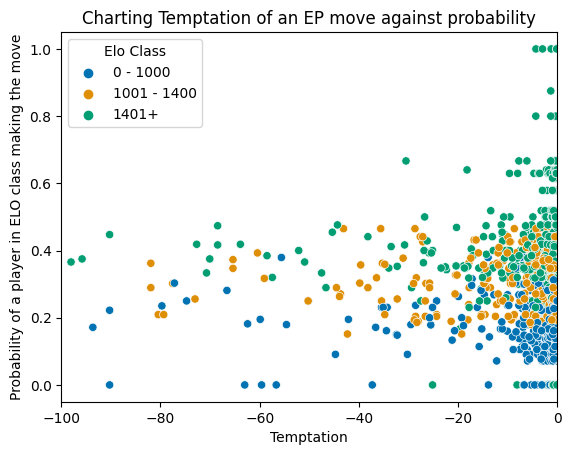

In [15]:
# set labels
elo_class_display = temptation_data["elo_class"].replace({
    1: "0 - 1000",
    2: "1001 - 1400",
    3: "1401+"
})

# make scatter plot
ax1 = sns.scatterplot(x=temptation_data["temptation"], y=temptation_data["quotient"], 
                hue=elo_class_display, palette="colorblind", hue_order=['0 - 1000', '1001 - 1400', '1401+'])

# retitle legend
sns.move_legend(ax1, title='Elo Class', loc='best')
# set labels
ax1.set_xlabel('Temptation')
ax1.set_ylabel('Probability of a player in ELO class making the move')
ax1.set_title('Charting Temptation of an EP move against probability')
# set x lim to not be a ridiculous number
ax1.set_xlim((-100, 0))

#### Distribution graph of Temptation throughout different Elo classes

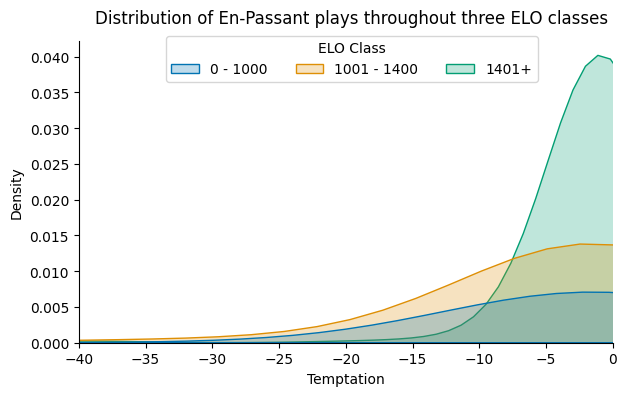

In [16]:
# only entries with an actual en passant capture
only_ep = temptation_data[temptation_data["ep_happened"] == True]

# long format for sns displot
grouped_class = pd.DataFrame(data=np.c_[only_ep["temptation"], only_ep["elo_class"]],
                             columns=["temptation", "elo_class"])

# make distribution plot
ax2 = sns.displot(data=grouped_class, x='temptation', hue='elo_class', kind="kde", 
                  fill=True, palette="colorblind", height=4, aspect=1.6)

# limit to -40, goes past that but the graph stays at 0 after this point
ax2.set(xlim=(-40, 0))

# title and labels
ax2.fig.suptitle("Distribution of En-Passant plays throughout three ELO classes", fontsize=12)
ax2.fig.subplots_adjust(top=0.9)
ax2.ax.set_xlabel("Temptation", fontsize=10)
ax2.ax.set_ylabel("Density", fontsize=10)

# legend
sns.move_legend(ax2, "upper center", ncol=3, title="ELO Class", bbox_to_anchor=(0.5, 0.93)
                , frameon=True)

# legend labels
new_labels = ['0 - 1000', '1001 - 1400', '1401+']
for t, l in zip(ax2._legend.texts, new_labels):
    t.set_text(l)

# save high quality image
plt.savefig('report/images/ep_distplot_exp.png', dpi=300)

#### Prepare unneccessary columns and set dummy variables for PCA 

In [17]:
def prep_temptation_dataframe(temptation_data):
    # Uneccessary columns for PCA
    temptation_data = temptation_data.drop(['fen', 'pgn', 'time_control', 'player_rating'], axis=1)
    temptation_data = temptation_data.drop(['eval_best', 'eval_ep', 'pre_eval', 'username'], axis=1)
    
    # Dummy variables
    temptation_data['ep_happened'] = temptation_data['ep_happened'].replace({True:1, False:0})
    temptation_data['ep_colour'] = temptation_data['ep_colour'].replace({'White':1, 'Black':0})
    temptation_data['rated'] = temptation_data['rated'].replace({True:1, False:0})
    temptation_data['time_class'] = temptation_data['time_class'].replace({'rapid':2, 'blitz':1, 'bullet':0})

    # Drop columns that don't contribute to PCA
    temptation_data = temptation_data.drop(['elo_class_tens'], axis=1)
    return temptation_data

# Drop games with repeated player names so that all records are independent
temptation_data = temptation_data.drop_duplicates(subset=['username'])

temptation_data = prep_temptation_dataframe(temptation_data)
print("Variables that will contribute to PCA")
print("-------------------------")
print(temptation_data.dtypes) # PCA hyperparameters

Variables that will contribute to PCA
-------------------------
ep_colour        int64
ep_happened      int64
rated            int64
time_class       int64
time_taken     float64
eval_player    float64
quotient       float64
temptation     float64
elo_class        int64
dtype: object


### Applying PCA and K-nearest Neighbours

#### (TESTING ONLY) Get coefficients for exponential model

In [18]:
def tempting(n, repeats):
    '''
    Repeats a temptation function to try and find the best coefficient for knn
    '''
    
    # copy and prep temptation data
    temptation_data = save_temptation_data.copy(deep=True)
    temptation_data = prep_temptation_dataframe(temptation_data)
    
    # features and labels
    elo_labels=temptation_data["elo_class"]
    elo_features=temptation_data.drop(columns=["elo_class"])

    # split data
    train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, test_size=0.2)

    # normalise
    scaler = StandardScaler()
    scaler.fit(train)

    # Apply transform to both the training set and the test set
    train = scaler.transform(train)
    test = scaler.transform(test)
    # Make an instance of the pca model
    pca = PCA(n_components=(len(temptation_data.columns)-1))
    pca.fit(train)

    # Transform images with pca model
    train_result = pca.transform(train)

    # get the highest accuracy number of neighbours
    kns = 0
    n_neighbors = 0
    for i in range (3,7):
        knn = KNeighborsClassifier(i)
        knn.fit(train_result, train_lbl)

        # Accuracy of knn test
        if knn.score(test, test_lbl) > kns:
            kns = knn.score(test, test_lbl)
            n_neighbors = i

    # repeat 100 times and get average value
    accuracy = 0
    for i in range(repeats):
        # print("optimal num: " + str(n_neighbors))
        knn = KNeighborsClassifier(n_neighbors)
        knn.fit(train_result, train_lbl)
        accuracy += knn.score(test, test_lbl)
    print(str(n) + " factor: " + str(accuracy/repeats))
    
    return accuracy/repeats

# for testing purposes only

# for i in range(1):
#     tempting(220, 100)

#### Apply PCA

In [19]:
# labels and features0
elo_labels=temptation_data["elo_class"]
elo_features=temptation_data.drop(columns=["elo_class"])

# split data
train, test, train_lbl, test_lbl = train_test_split(elo_features, elo_labels, stratify=elo_labels, test_size=0.2)

# standardise
scaler = StandardScaler()
scaler.fit(train)

# Apply transform to both the training set and the test set
train = scaler.transform(train)
test = scaler.transform(test)

# Make an instance of the pca model
pca = PCA(n_components=(len(temptation_data.columns)-1))
pca.fit(train)
print("variance ratio: ")
print(pca.explained_variance_ratio_)

# Transform images with pca model
train_result = pca.transform(train)
test_result = pca.transform(test)

variance ratio: 
[0.16854437 0.15410579 0.13683406 0.12836424 0.12087494 0.11241464
 0.09750541 0.08135656]


#### Apply k-Nearest Neighbours

In [20]:
# set up data
X_data = train_result[:,:2] # This needs 2cols for knn graph
y = train_lbl

# get the highest accuracy number of neighbours
clf = KNeighborsClassifier(5, weights='uniform')
clf.fit(X_data, y)

# create knn classifier

accuracy = clf.score(test[:,:2], test_lbl)
print(f'Accuracy: {accuracy}')

# For k-NN metrics later
# test_predictions is the categories the classifier predicted for the test set's data
test_predictions = clf.predict(test[:,:2])

Accuracy: 0.3470031545741325


#### Display KNN Boundary Chart

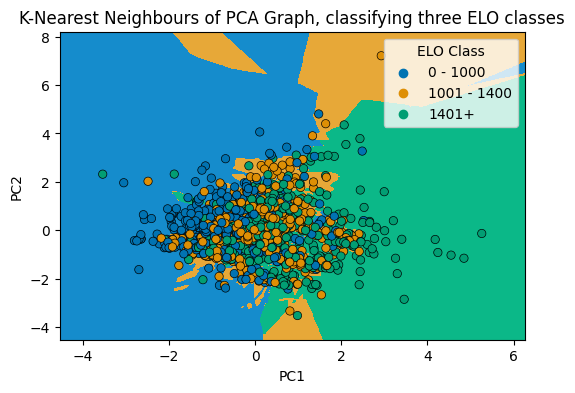

In [21]:
# Meshgrid size
h = .02

# Make mesh grid
x_min, x_max = X_data[:, 0].min() - 1, X_data[:, 0].max() + 1
y_min, y_max = X_data[:, 1].min() - 1, X_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

Z = np.array(Z, dtype=float)

# Create fig
fig, ax3 = plt.subplots(figsize=(6,4))

# colour palettes of sns colour blind imported as matplotlib colours
cmap_1 = ListedColormap(sns.color_palette("colorblind"))
hex_cols = sns.color_palette("colorblind").as_hex()

# cols = ["#BFDBEB", "#F6E2C0", "#BFE6DB"]  # same hue as sns fill
cols = ["#158ccc", "#e7a838", "#0bb888"]    # custom darker colours
cmap_2 = ListedColormap(cols) 

# plot contours using darker colours
plt.contourf(xx, yy, Z, cmap=cmap_2)

# hue labels
hue_labels = ['0 - 1000', '1001 - 1400', '1401+']

# Labels for classes
train_lbl = train_lbl.replace({
    1: hue_labels[0],
    2: hue_labels[1],
    3: hue_labels[2]
})

# Plot data
ax3 = sns.scatterplot(x=X_data[:, 0], y=X_data[:, 1], hue=train_lbl,
palette="colorblind", alpha=1.0, edgecolor="black", hue_order=hue_labels)
sns.move_legend(ax3, title='ELO Class', loc='best')

# Set graph dimensions
ax3.set_xlim(xx.min(), xx.max())
ax3.set_ylim(yy.min(), yy.max())

# Label axes
ax3.set_title("K-Nearest Neighbours of PCA Graph, classifying three ELO classes", fontsize=12)
ax3.set_xlabel("PC1", fontsize=10)
ax3.set_ylabel("PC2", fontsize=10)

# save high quality image
plt.savefig('report/images/knn_graph_exp.png', dpi=300)

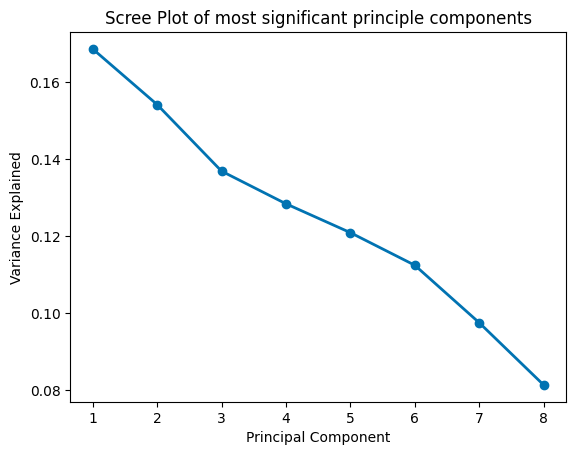

In [22]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color=hex_cols[0])
plt.title('Scree Plot of most significant principle components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [23]:
# Actual is the y-axis on confusion matrix for 1, 2, 3 going downwards
confusion = confusion_matrix(test_predictions, test_lbl)
print('Confusion matrix:\n    Predicted\n    1   2   3')
print(confusion_matrix(test_predictions, test_lbl))
print('Precision score: ', precision_score(test_predictions, test_lbl, average='weighted'))
print('Recall score: ', recall_score(test_predictions, test_lbl, average='weighted'))
print('F1 score: ', f1_score(test_predictions, test_lbl, average='weighted'))
print('Accuracy: ', accuracy_score(test_predictions, test_lbl))


# Additional metrics

def sensitivity(TP, FN):
    '''Returns sensitivity of a class given the number of its true positives TP and false negatives FN.'''
    return TP / (TP + FN)

def selectivity(TN, FP):
    '''Returns selectivity of a class given the number of its true negatives TN and false positives FP.'''
    return TN / (TN + FP)

# Class 1
TP_1 = confusion[0][0]
TN_1 = confusion[1][1] + confusion[1][2] + confusion[2][1] + confusion[2][2]
FP_1 = confusion[0][1] + confusion[0][2]
FN_1 = confusion[1][0] + confusion[2][0]

# Class 2
TP_2 = confusion[1][1]
TN_2 = confusion[0][0] + confusion[0][2] + confusion[2][0] + confusion[2][2]
FP_2 = confusion[1][0] + confusion[1][2]
FN_2 = confusion[0][1] + confusion[2][1]

# Class 3
TP_3 = confusion[2][2]
TN_3 = confusion[0][0] + confusion[0][1] + confusion[1][0] + confusion[1][1]
FP_3 = confusion[2][0] + confusion[2][1]
FN_3 = confusion[0][2] + confusion[1][2]


print('Sensitivity of 1: ', sensitivity(TP_1, FN_1))
print('Sensitivity of 2: ', sensitivity(TP_2, FN_2))
print('Sensitivity of 3: ', sensitivity(TP_3, FN_3))

Confusion matrix:
    Predicted
    1   2   3
[[ 3  8 10]
 [43 37 22]
 [53 71 70]]
Precision score:  0.5246312343752211
Recall score:  0.3470031545741325
F1 score:  0.40198930589200615
Accuracy:  0.3470031545741325
Sensitivity of 1:  0.030303030303030304
Sensitivity of 2:  0.31896551724137934
Sensitivity of 3:  0.6862745098039216
